# Import libraries


In [19]:
%matplotlib inline
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs
from os.path import join, exists, expanduser
from tqdm import tqdm
from sklearn.metrics import log_loss, accuracy_score
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50

# Use Keras Pretrained Models dataset

Kernels can't use network connection to download pretrained keras model weights.
This dataset helps you to apply your favorite pretrained model in the Kaggle Kernel environment. 
You can find more details [here](https://www.kaggle.com/gaborfodor/keras-pretrained-models).

We have to copy the pretrained models to the cache directory (~/.keras/models) where keras is looking for them.


In [1]:
!ls ../input/keras-pretrained-models/

Kuszma.JPG
imagenet_class_index.json
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5
inception_v3_weights_tf_dim_ordering_tf_kernels.h5
inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
resnet50_weights_tf_dim_ordering_tf_kernels.h5
resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
xception_weights_tf_dim_ordering_tf_kernels.h5
xception_weights_tf_dim_ordering_tf_kernels_notop.h5


In [5]:
cache_dir = expanduser(join('~', '.keras'))
if not exists(cache_dir):
    makedirs(cache_dir)
models_dir = join(cache_dir, 'models')
if not exists(models_dir):
    makedirs(models_dir)

In [6]:
!cp ../input/keras-pretrained-models/*notop* ~/.keras/models/
!cp ../input/keras-pretrained-models/imagenet_class_index.json ~/.keras/models/
!cp ../input/keras-pretrained-models/resnet50* ~/.keras/models/

In [7]:
!ls ~/.keras/models

imagenet_class_index.json
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5
inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
resnet50_weights_tf_dim_ordering_tf_kernels.h5
resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
xception_weights_tf_dim_ordering_tf_kernels_notop.h5


In [8]:
!ls ../input/dog-breed-identification

labels.csv  sample_submission.csv  test  train


# Using only the specified classes


In [9]:
INPUT_SIZE = 224
SEED = 1987
data_dir = '../input/dog-breed-identification'
labels = pd.read_csv(join(data_dir, 'labels.csv'))
sample_submission = pd.read_csv(join(data_dir, 'sample_submission.csv'))
print(len(listdir(join(data_dir, 'train'))), len(labels))
print(len(listdir(join(data_dir, 'test'))), len(sample_submission))

10222 10222
10357 10357


In [10]:
selected_breed_list = ['beagle', 'chihuahua', 'doberman', 'french_bulldog', 'golden_retriever', 'malamute', 'pug', 'saint_bernard', 'scottish_deerhound','tibetan_mastiff']
labels = labels[labels['breed'].isin(selected_breed_list)]
labels['target'] = 1
labels['rank'] = labels.groupby('breed').rank()['id']
labels_pivot = labels.pivot('id', 'breed', 'target').reset_index().fillna(0)
np.random.seed(seed=SEED)
rnd = np.random.random(len(labels))
train_idx = rnd < 0.8
valid_idx = rnd >= 0.8
y_train = labels_pivot[selected_breed_list].values
ytr = y_train[train_idx]
yv = y_train[valid_idx]
score = []

In [11]:
def read_img(img_id, train_or_test, size):
    """Read and resize image.
    # Arguments
        img_id: string
        train_or_test: string 'train' or 'test'.
        size: resize the original image.
    # Returns
        Image as numpy array.
    """
    img = image.load_img(join(data_dir, train_or_test, '%s.jpg' % img_id), target_size=size)
    img = image.img_to_array(img)
    return img

# ResNet50 class predictions for example images

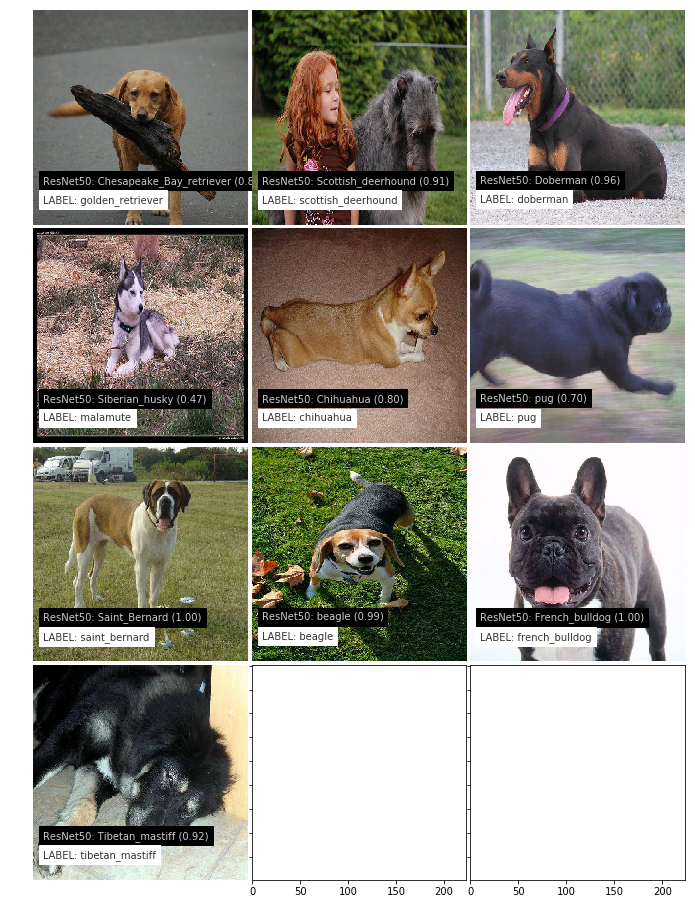

In [20]:
NUM_CLASSES = 10
model = ResNet50(weights='imagenet')
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
j = int(np.sqrt(NUM_CLASSES))
i = int(np.ceil(1. * NUM_CLASSES / j))
fig = plt.figure(1, figsize=(16, 16))
grid = ImageGrid(fig, 111, nrows_ncols=(i, j), axes_pad=0.05)
for i, (img_id, breed) in enumerate(labels.loc[labels['rank'] == 1, ['id', 'breed']].values):
    ax = grid[i]
    img = read_img(img_id, 'train', (224, 224))
    ax.imshow(img / 255.)
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    preds = model.predict(x)
    _, imagenet_class_name, prob = decode_predictions(preds, top=1)[0][0]
    ax.text(10, 180, 'ResNet50: %s (%.2f)' % (imagenet_class_name , prob), color='w', backgroundcolor='k', alpha=0.8)
    ax.text(10, 200, 'LABEL: %s' % breed, color='k', backgroundcolor='w', alpha=0.8)
    ax.axis('off')
plt.show()

In [21]:
for i, (img_id, breed) in enumerate(labels.loc[labels['rank'] == 1, ['id', 'breed']].values):
    ax = grid[i]
    img = read_img(img_id, 'train', (224, 224))
    ax.imshow(img / 255.)
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    preds = model.predict(x)
    score.append([decode_predictions(preds, top=1)[0][0]])
    

In [36]:
acc = []
for elem in score:
    main = elem[0]
    acc.append(main[2])

import math
np.average(acc)

0.85649842

Preprocessing and prediction seems to be working. 85% accuracy on these 9 images.

In [23]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin